<a href="https://colab.research.google.com/github/nitrogenlab/pyompa/blob/main/examples/No_metabolism_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demonstrating an example where the parameters are just salinity and temperature

Install pyompa

In [2]:
!pip install pyompa

  Preparing metadata (setup.py) ... done
  Created wheel for pyompa: filename=pyompa-0.4.2.1-py3-none-any.whl size=28076 sha256=f30d09fd46f7e256f1ac9fd01928013b3e658ff09d047958d7d46a06d05cdb00
  Stored in directory: /root/.cache/pip/wheels/d2/c0/2c/1ddbcb3ebf48e035f9ac6cb7a96052aee903d86f21808d96da
Successfully built pyompa


Download the input data (this was provided by Natalya Evans)

In [3]:
!wget https://raw.githubusercontent.com/nitrogenlab/pyompa/cee3123/examples/FK_ompa_04s.mat -O FK_ompa_04s.mat

--2024-02-08 21:49:15--  https://raw.githubusercontent.com/nitrogenlab/pyompa/cee3123/examples/FK_ompa_04s.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38252 (37K) [application/octet-stream]
Saving to: ‘FK_ompa_04s.mat’

FK_ompa_04s.mat     100%[===================>]  37.36K  --.-KB/s    in 0.004s  

2024-02-08 21:49:16 (8.54 MB/s) - ‘FK_ompa_04s.mat’ saved [38252/38252]



Load the input data

In [4]:
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np

inp_data = loadmat("FK_ompa_04s.mat")

#Prepare a data frame for the Falkor data

falkor_df = pd.DataFrame({
    'lat': inp_data['lat'].flatten(),
    'long': inp_data['long'].flatten(),
    'pdens': inp_data['pdens'].flatten(),
    'conservative_temp': inp_data['ptemp'].flatten(),
    'absolute_salinity': inp_data['sal'].flatten(),
})
#If we were using the hard mass conservation constraint, it would not be
# necessary to specify this "mass" variable; however, to replicate the MATLAB
# OMP analysis, we have to create a separate variable for mass
falkor_df["mass"] = 1.0

#Filter the data frame to density ranges used for intermedite waters
intermediatewaters_falkordf = pd.DataFrame(
    falkor_df[(falkor_df["pdens"] >= 26.0)
              & (falkor_df["pdens"] <= 27.0)])

Define the end-members

In [5]:
#                                   temp       sal
CW13_FK =        ["13CW_FK",       12.54,    34.98]
NEPIW_FK =       ["NEPIW_FK",       9.56,    34.80]
AAIW =           ["AAIW",           6.03,    34.70]

def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "conservative_temp", "absolute_salinity"])
    return df

intermediatewaters_FK_endmemberdf = prepare_endmember_df(
    [CW13_FK, NEPIW_FK, AAIW])


Define the pyompa parameters to replicate the matlab OMP analysis, and run the analysis

In [6]:
import pyompa

evansorig_paramweightings = {
    "conservative_temp": 24.0,
    "absolute_salinity": 24.0,
}

evansorig_settings = {
    "param_names": ["conservative_temp", "absolute_salinity"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": [],
    "sumtooneconstraint": True
}

#Run the analysis, replicating the MATLAB OMP analysis
orig_intermediate_falkordf_ompasoln = pyompa.OMPAProblem(
  obs_df = intermediatewaters_falkordf,
  **evansorig_settings).solve(
      intermediatewaters_FK_endmemberdf,
      endmember_name_column="endmember_name")

Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['conservative_temp', 'absolute_salinity']
param weighting: [24. 24.]
Matrix A:
On example 0 to 279 out of 279
status: optimal
optimal value 20491.808279380486
Original weighted sum squares: 20491.808279380486
Post fix weighted sum squared: 20491.808279578465
objective: 20491.808279578465


Display the results

Water mass fractions


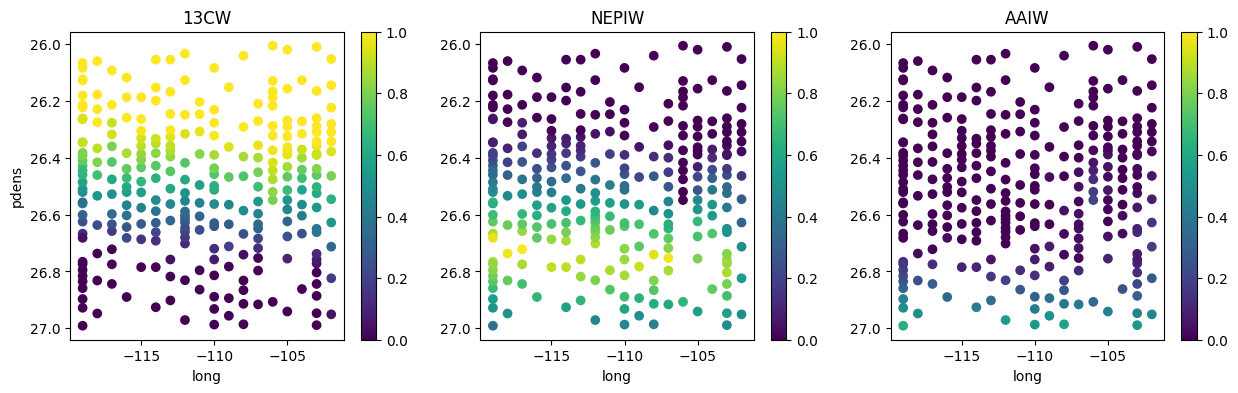

Residuals


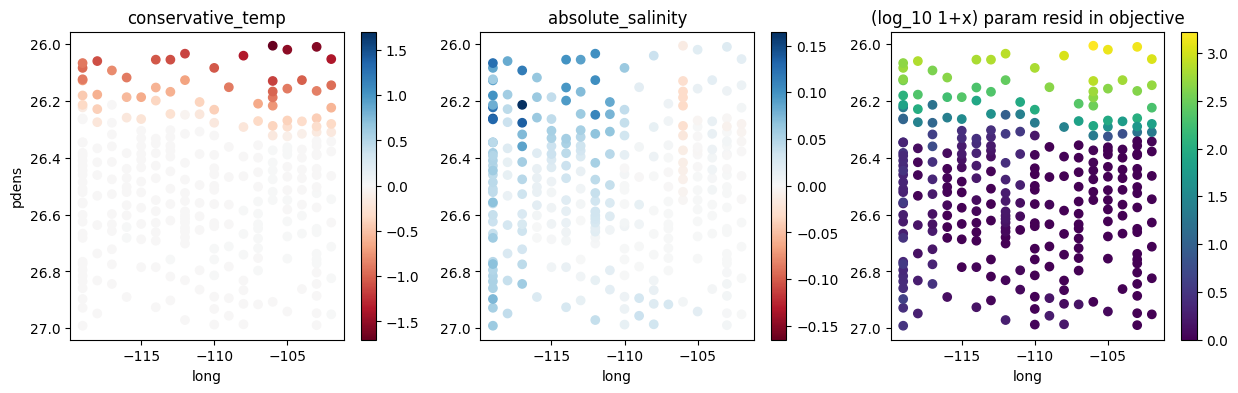

In [7]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,
                    plot_ompasoln_residuals,
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "pdens"
print("Water mass fractions")
plot_ompasoln_endmember_fractions(ompa_soln=orig_intermediate_falkordf_ompasoln,
                                  xaxis_colname="long",
                                  yaxis_colname=yaxis_colname)
print("Residuals")
plot_ompasoln_residuals(ompa_soln=orig_intermediate_falkordf_ompasoln,
                        xaxis_colname="long",
                        yaxis_colname=yaxis_colname)